In [6]:
import os, glob, re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pandas as pd


In [7]:
def get_experiment(hash, experiment_dir):
    path = f"data/{hash}/{experiment_dir}"
    all_data = []
    
    # get all experiment directories
    experiment_dirs = glob.glob(f"{path}/experiment_*")
    
    for exp_dir in experiment_dirs:
        exp_name = os.path.basename(exp_dir)
        session_dirs = glob.glob(f"{exp_dir}/*TrainingSession_*")
        exp_data = {'experiment_name': exp_name}
        
        for session_dir in session_dirs:
            #get first word (e.g., "SNNTrainingSession" -> "SNN")
            session_type = os.path.basename(session_dir).split('Training')[0]            
            
            
            with open(os.path.join(session_dir, "metrics.json"), 'r') as f:
                metrics = json.load(f)
                
                
            #TODO: NEED TO COMPUTE CF METRICS BY SELF !!!!
            with open(os.path.join(session_dir, "cf_metrics.json"), 'r') as f:
                cf_metrics = json.load(f)
                
            for k, v in metrics.items():
                exp_data[f"{session_type}_{k}"] = v
            for k, v in cf_metrics.items():
                exp_data[f"{session_type}_{k}"] = v
                
        all_data.append(exp_data)
    
    df = pd.DataFrame(all_data)
    
    return df


In [183]:
def compute_omega_base(alpha_ideal, num_training_sessions, alphas):
    T = num_training_sessions
    omega_base = np.sum(alphas[1:])#skip the first session like in the paper
    omega_base /= ((T-1) * alpha_ideal)
    return omega_base
    
def compute_omega_all(alpha_ideal, num_training_sessions, alphas):
    T = num_training_sessions
    omega_all = np.sum(alphas)
    omega_all /= ((T-1)  * alpha_ideal)
    return omega_all

def compute_omega_new(alpha_ideal, num_training_sessions, alphas):
    T = num_training_sessions
    omega_new = np.sum(alphas)
    omega_new /= (T-1)
    return omega_new

def compute_omega(metric_key, alpha_ideal, num_sessions, baseline_sessions, model_sessions):
    functions = {
        'base': compute_omega_base,
        'all': compute_omega_all,
        'new': compute_omega_new
    }
    func = functions.get(metric_key)
    
    if func:
        baseline_values = np.array(baseline_sessions.apply(lambda x: 
            func(alpha_ideal=alpha_ideal, num_training_sessions=num_sessions, alphas=x)))
        
        values = np.array(model_sessions.apply(lambda x: 
            func(alpha_ideal=alpha_ideal, num_training_sessions=num_sessions, alphas=x)))
        
        return baseline_values, values
    else:
        raise ValueError(f"Unsupported metric: {metric_key}")


def plot_cf_metrics(df, model="SNN", title="", ax=None):
    metrics_data = []
    alpha_ideal_offline_MLP = df['Baseline_alpha_ideal'].mean()
    
    for metric in ['base', 'new', 'all']:
        all_baseline_alpha_sessions = df[f'Baseline_alpha_{metric}_sessions'].apply(lambda x: np.array(x))
        all_model_alpha_sessions = df[f'{model}_alpha_{metric}_sessions'].apply(lambda x: np.array(x))

        T1 = len(all_baseline_alpha_sessions.iloc[0])
        T2 = len(all_model_alpha_sessions.iloc[0])
        assert T1 == T2, f"Number of training sessions differ: {T1} != {T2}"
        
        baseline_values, values = compute_omega(
            metric, 
            alpha_ideal=alpha_ideal_offline_MLP, 
            num_sessions=T1, 
            baseline_sessions=all_baseline_alpha_sessions, 
            model_sessions=all_model_alpha_sessions
        )
        
        metrics_data.extend([('Ω_' + metric, 'Baseline', v) for v in baseline_values])
        metrics_data.extend([('Ω_' + metric, model, v) for v in values])
    
    plot_df = pd.DataFrame(metrics_data, columns=['Metric', 'Method', 'Value'])
    
    sns.boxplot(ax=ax, data=plot_df, x='Metric', y='Value', hue='Method')
    ax.set_title(f'{model} vs Baseline: {title}')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper right')


def plot_session_evolution(df, model="SNN", title="", ax_list=None):
    alpha_ideal_offline_MLP = df['Baseline_alpha_ideal'].mean()
    metrics = ['base', 'new', 'all']
    line_styles = ['-', '-', '-']

    for ax, metric, line_style in zip(ax_list, metrics, line_styles):
        baseline_alpha_sessions = df[f'Baseline_alpha_{metric}_sessions'].apply(lambda x: np.array(x))
        model_alpha_sessions = df[f'{model}_alpha_{metric}_sessions'].apply(lambda x: np.array(x))

        baseline_alpha_mean = np.mean(np.stack(baseline_alpha_sessions.values), axis=0)
        baseline_alpha_std = np.std(np.stack(baseline_alpha_sessions.values), axis=0)
        
        model_alpha_mean = np.mean(np.stack(model_alpha_sessions.values), axis=0)
        model_alpha_std = np.std(np.stack(model_alpha_sessions.values), axis=0)

        T1 = len(baseline_alpha_mean)
        session_indices = np.arange(1, T1 + 1)
        
        sns.lineplot(ax=ax, x=session_indices, y=baseline_alpha_mean, label='Baseline', linestyle=line_style, marker='o')
        ax.fill_between(session_indices, baseline_alpha_mean - baseline_alpha_std, 
                        baseline_alpha_mean + baseline_alpha_std, alpha=0.2)
        
        sns.lineplot(ax=ax, x=session_indices, y=model_alpha_mean, label=f'{model}', linestyle=line_style, marker='o')
        ax.fill_between(session_indices, model_alpha_mean - model_alpha_std, 
                        model_alpha_mean + model_alpha_std, alpha=0.2)

        ax.axhline(y=alpha_ideal_offline_MLP, color='r', linestyle='--', linewidth=1, label='Alpha Ideal')
        ax.set_title(f'Alpha {metric.capitalize()}')
        ax.set_xlabel('Training Session')
        ax.set_ylabel('Alpha')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='upper right')
        

### baseline vs SNN

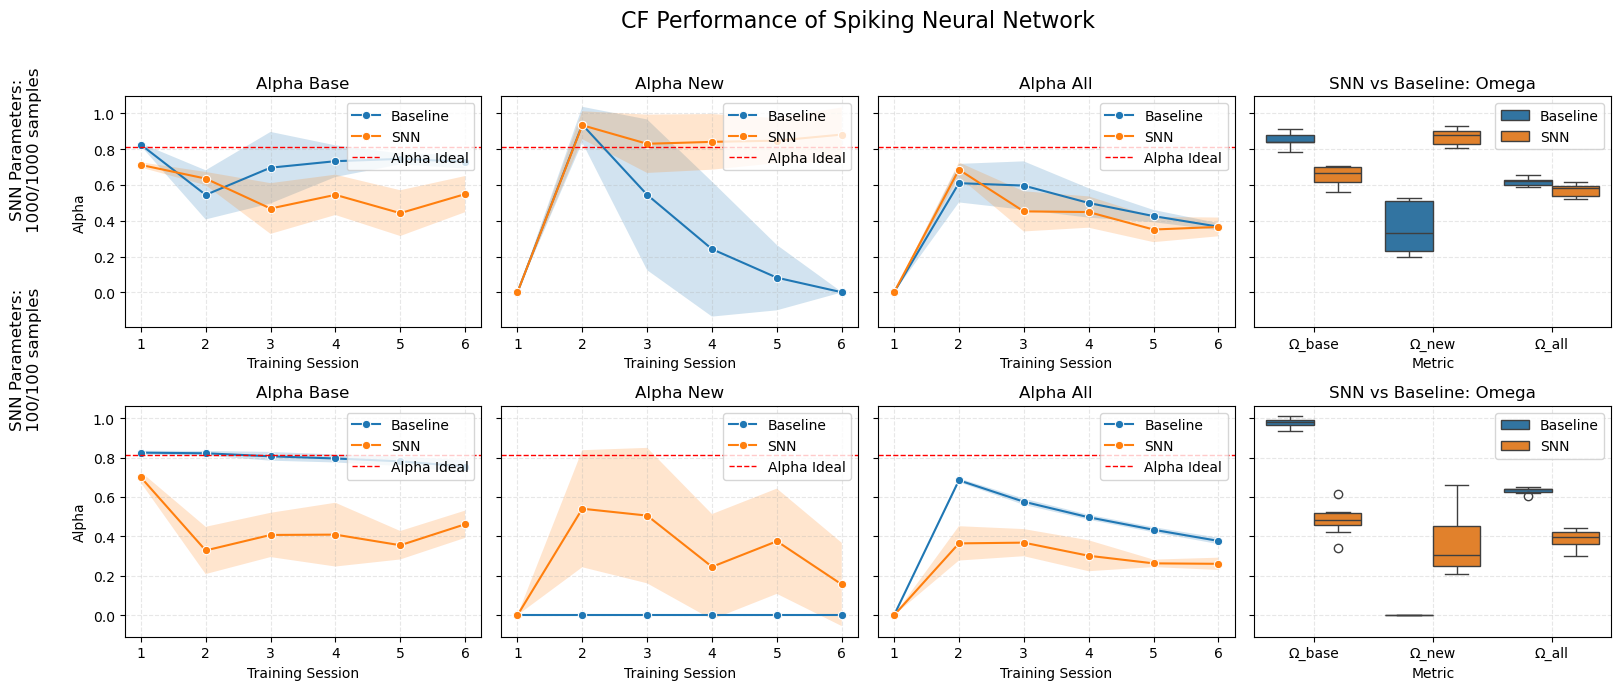

In [248]:
df_snn = get_experiment("accc798", "#2_SNN")
df_snn2 = get_experiment("accc798", "#2_SNNb")
dfs = [df_snn, df_snn2]


fig, axes = plt.subplots(len(dfs), 4, figsize=(16, 7), sharey='row')
fig.subplots_adjust(hspace=0.7, wspace=0.3)

titles = ["SNN Parameters:\n1000/1000 samples", "SNN Parameters:\n100/100 samples"]

#overall plot title
fig.suptitle("CF Performance of Spiking Neural Network", fontsize=16)

for i, (df, title) in enumerate(zip(dfs, titles)):
    plot_session_evolution(df, model="SNN", title=title, ax_list=axes[i, :])
    plot_cf_metrics(df, model="SNN", title="Omega", ax=axes[i, -1])
    
    y_pos = 0.78 - i * 0.3  
    fig.text(-0.02, y_pos, title, ha='center', va='center', size='large', rotation=90)

plt.tight_layout(rect=[0, 0, 0.98, 0.96])
plt.show()

## baseline vs GA

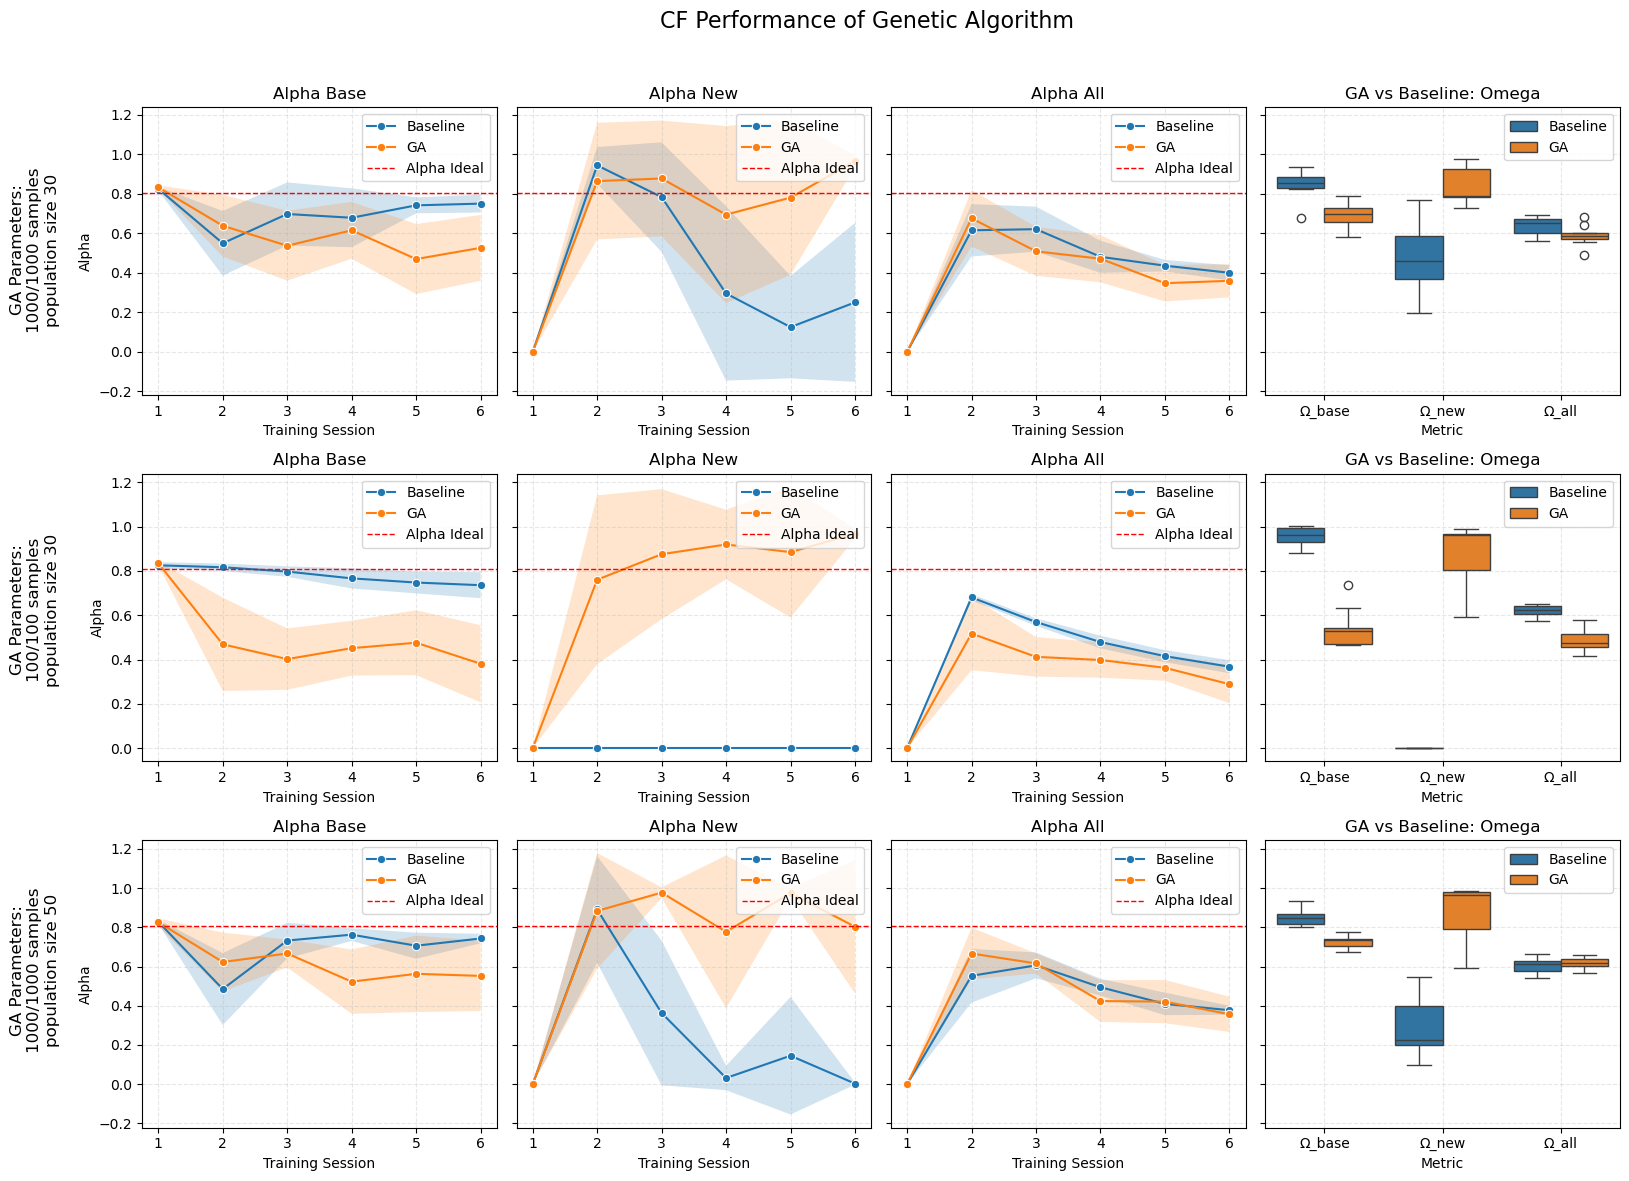

In [249]:
df_ga = get_experiment("e5af9d9", "#1_lasso")
df_ga2 = get_experiment("e5af9d9", "#1_16020914_NO")
df_ga3 = get_experiment("e5af9d9", "#1_16020450_IS")

fig, axes = plt.subplots(3, 4, figsize=(16, 12), sharey='row')
fig.subplots_adjust(hspace=0.7, wspace=0.3)

dfs = [df_ga, df_ga3, df_ga2]
titles = ["GA Parameters:\n1000/1000 samples\npopulation size 30", "GA Parameters:\n100/100 samples\npopulation size 30", "GA Parameters:\n1000/1000 samples\npopulation size 50"]

#overall plot title
fig.suptitle("CF Performance of Genetic Algorithm", fontsize=16)

for i, (df, title) in enumerate(zip(dfs, titles)):
    plot_session_evolution(df, model="GA", title=title, ax_list=axes[i, :])
    plot_cf_metrics(df, model="GA", title="Omega", ax=axes[i, -1])
    
    y_pos = 0.78 - i * 0.3  
    fig.text(-0.02, y_pos, title, ha='center', va='center', size='large', rotation=90)

plt.tight_layout(rect=[0, 0, 0.98, 0.96])
plt.show()


In [255]:
df_pygad = get_experiment("yi", "pygad_fmnist")

df_pygad

,experiment_name,Baseline_alpha_base_sessions,Baseline_alpha_new_sessions,Baseline_alpha_all_sessions,Baseline_alpha_ideal,Baseline_session_classes,Baseline_omega_base,Baseline_omega_new,Baseline_omega_all,PyGAD_alpha_base_sessions,PyGAD_alpha_new_sessions,PyGAD_alpha_all_sessions,PyGAD_alpha_ideal,PyGAD_session_classes,PyGAD_omega_base,PyGAD_omega_new,PyGAD_omega_all
0,experiment_pygad_5_20250115-152543,"[0.8414, 0.538, 0.7806, 0.7832, 0.7658, 0.7826]","[0, 1.0, 0.003, 0.0, 0.0, 0.0]","[0, 0.615, 0.6222857142857143, 0.4895, 0.42544...",0.8220,"[[0, 1, 2, 3, 4], [7], [6], [5], [8], [9]]",0.888127,0.2006,0.618864,"[0.8092, 0.738, 0.4892, 0.7368, 0.717, 0.7556]","[0, 0.998, 0.834, 0.999, 0.97, 0.992]","[0, 0.7813333333333333, 0.4685714285714286, 0....",0,"[[0, 1, 2, 3, 4], [9], [6], [7], [8], [5]]",inf,0.9586,inf
1,experiment_pygad_3_20250115-152543,"[0.836, 0.4888, 0.797, 0.801, 0.7612, 0.7898]","[0, 0.999, 0.001, 0.003, 0.0, 0.0]","[0, 0.5738333333333333, 0.5754285714285714, 0....",0.7868,"[[0, 1, 2, 3, 4], [9], [5], [6], [8], [7]]",0.924708,0.2006,0.629525,"[0.8184, 0.7088, 0.699, 0.749, 0.731, 0.3992]","[0, 0.992, 0.977, 0.999, 0.999, 0.89]","[0, 0.756, 0.6388571428571429, 0.593, 0.517111...",0,"[[0, 1, 2, 3, 4], [5], [8], [7], [9], [6]]",inf,0.9714,inf
2,experiment_pygad_0_20250115-152543,"[0.8268, 0.3422, 0.7506, 0.798, 0.795, 0.7942]","[0, 0.998, 0.001, 0.0, 0.002, 0.0]","[0, 0.4515, 0.5544285714285714, 0.49875, 0.441...",0.7726,"[[0, 1, 2, 3, 4], [9], [6], [5], [7], [8]]",0.900854,0.2002,0.606696,"[0.7948, 0.708, 0.6162, 0.396, 0.716, 0.7384]","[0, 1.0, 0.954, 0.873, 0.998, 0.999]","[0, 0.7566666666666667, 0.5764285714285714, 0....",0,"[[0, 1, 2, 3, 4], [7], [8], [6], [9], [5]]",inf,0.9648,inf
3,experiment_pygad_1_20250115-152543,"[0.826, 0.387, 0.7562, 0.7904, 0.7536, 0.7784]","[0, 0.975, 0.0, 0.345, 0.0, 0.0]","[0, 0.485, 0.5408571428571428, 0.5375, 0.41955...",0.7192,"[[0, 1, 2, 3, 4], [8], [5], [9], [6], [7]]",0.963737,0.2640,0.659653,"[0.8312, 0.7138, 0.75, 0.7596, 0.7234, 0.4186]","[0, 0.98, 0.997, 0.999, 0.997, 0.881]","[0, 0.7581666666666667, 0.6781428571428572, 0....",0,"[[0, 1, 2, 3, 4], [8], [9], [7], [5], [6]]",inf,0.9708,inf
4,experiment_pygad_4_20250115-152543,"[0.819, 0.409, 0.7558, 0.7264, 0.7254, 0.7252]","[0, 0.997, 0.0, 0.612, 0.019, 0.0]","[0, 0.507, 0.6208571428571429, 0.55025, 0.4612...",0.7698,"[[0, 1, 2, 3, 4], [7], [6], [9], [8], [5]]",0.868226,0.3256,0.650021,"[0.8312, 0.7204, 0.4224, 0.7088, 0.6924, 0.768]","[0, 0.991, 0.85, 0.997, 0.973, 1.0]","[0, 0.7655, 0.42314285714285715, 0.567625, 0.4...",0,"[[0, 1, 2, 3, 4], [5], [6], [9], [8], [7]]",inf,0.9622,inf
5,experiment_pygad_2_20250115-152543,"[0.8478, 0.5178, 0.8148, 0.7836, 0.7898, 0.6894]","[0, 0.948, 0.979, 0.008, 0.0, 0.014]","[0, 0.5895, 0.7224285714285714, 0.543875, 0.43...",0.8106,"[[0, 1, 2, 3, 4], [8], [9], [5], [7], [6]]",0.887096,0.3898,0.651661,"[0.8258, 0.7716, 0.7272, 0.743, 0.3896, 0.7038]","[0, 0.995, 0.994, 1.0, 0.861, 0.948]","[0, 0.8088333333333333, 0.6614285714285715, 0....",0,"[[0, 1, 2, 3, 4], [9], [5], [7], [6], [8]]",inf,0.9596,inf


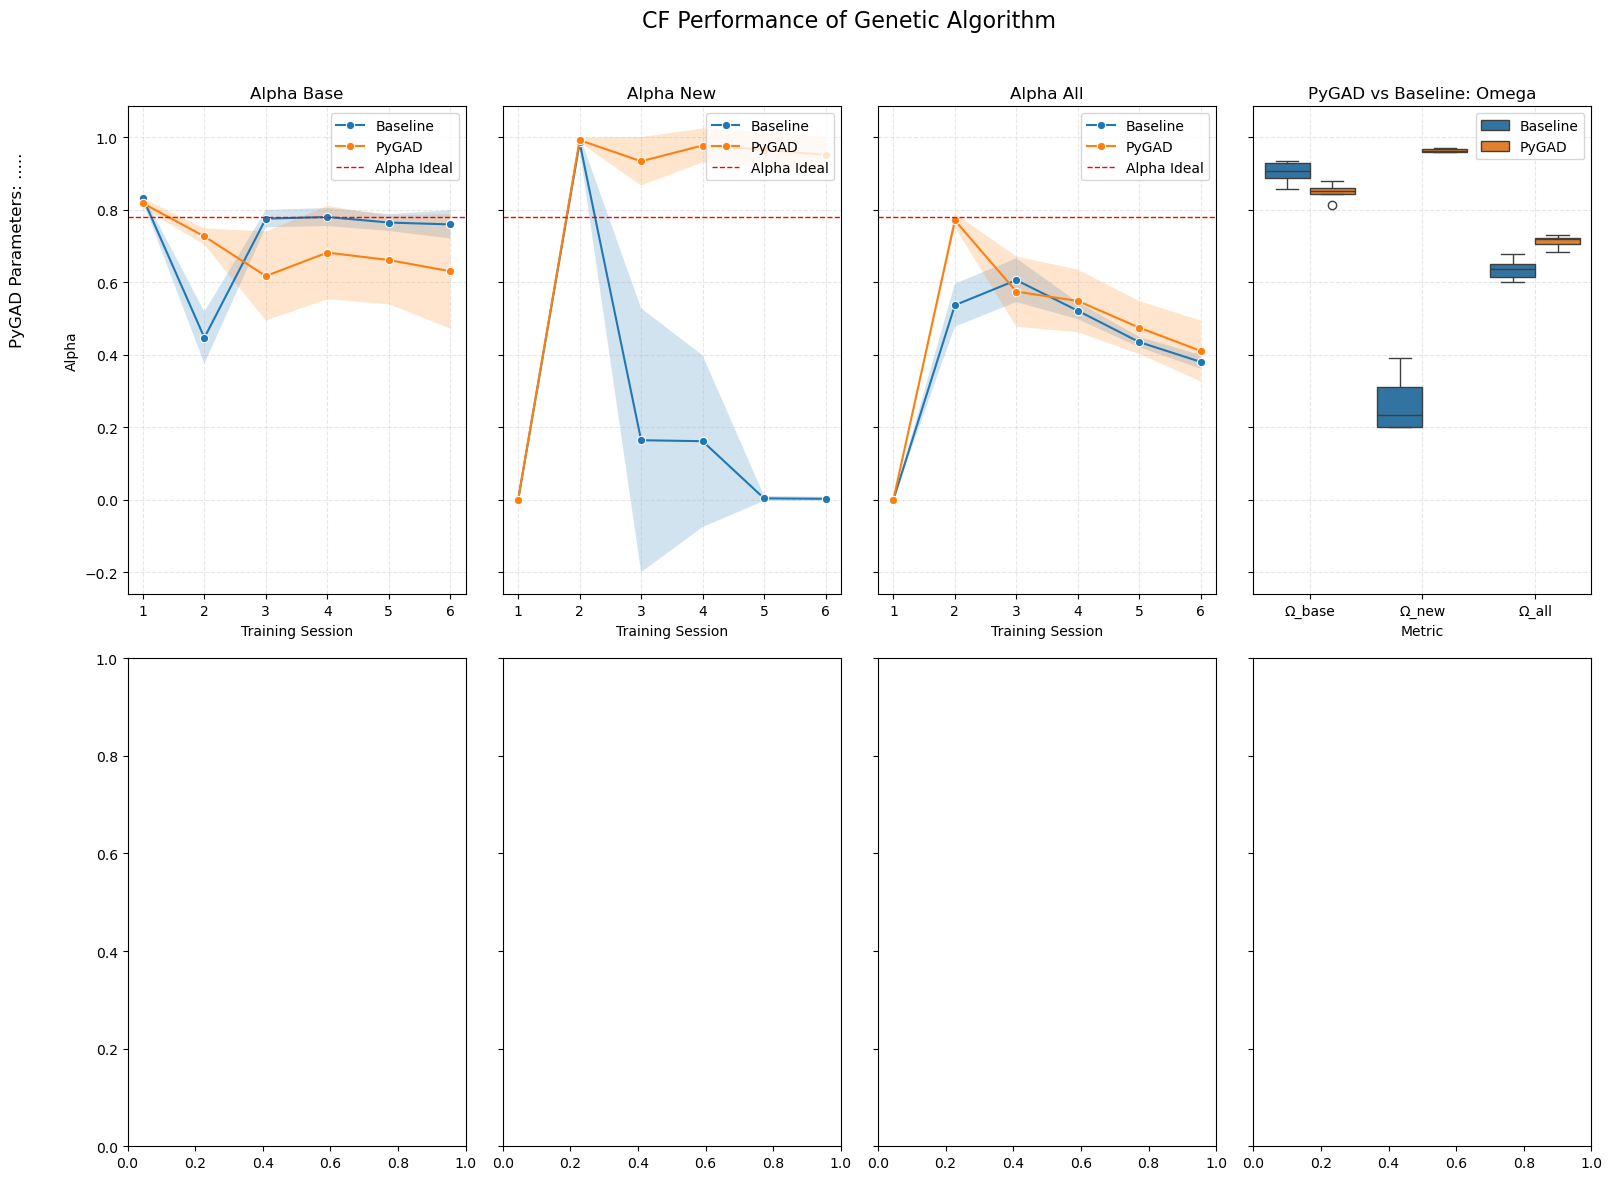

In [ ]:


fig, axes = plt.subplots(2, 4, figsize=(16, 7), sharey='row')
fig.subplots_adjust(hspace=0.7, wspace=0.3)

dfs = [df_pygad]
titles = ["PyGAD Parameters: ....."]

#overall plot title
fig.suptitle("CF Performance of Genetic Algorithm", fontsize=16)

for i, (df, title) in enumerate(zip(dfs, titles)):
    plot_session_evolution(df, model="PyGAD", title=title, ax_list=axes[i, :])
    plot_cf_metrics(df, model="PyGAD", title="Omega", ax=axes[i, -1])
    
    y_pos = 0.78 - i * 0.3  
    fig.text(-0.02, y_pos, title, ha='center', va='center', size='large', rotation=90)

plt.tight_layout(rect=[0, 0, 0.98, 0.96])
plt.show()
